In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dython import nominal

from sklearn.preprocessing import MinMaxScaler

Read in our data:

In [225]:
train_df = pd.read_csv('data/census_income_learn_clean.csv')
test_df = pd.read_csv('data/census_income_test_clean.csv')

Let's begin by choosing our features. I am going to choose the most highly correlated features with `wage` that we saw in the previous notebook, this will hopefully help remove any redundant information from the dataset and also simplify any potential model we train in the future to help with interpretability and also overfitting

In [226]:
# features = ['education', 'class of worker', 'detailed industry recode', 'major industry code', 'major occupation code',
#             'sex', 'capital gains', 'dividends from stocks', 'tax filer stat', 'detailed household and family stat',
#             'detailed household summary in household', 'num persons worked for employer', 'weeks worked in year']

features = ['age','education', 'class of worker', 'detailed industry recode', 'major industry code', 'major occupation code',
            'sex', 'capital gains', 'dividends from stocks', 'tax filer stat', 'detailed household and family stat',
            'detailed household summary in household', 'num persons worked for employer', 'weeks worked in year']


target = 'wage'

In [227]:
train_df = train_df[features + [target]]
test_df = test_df[features + [target]]

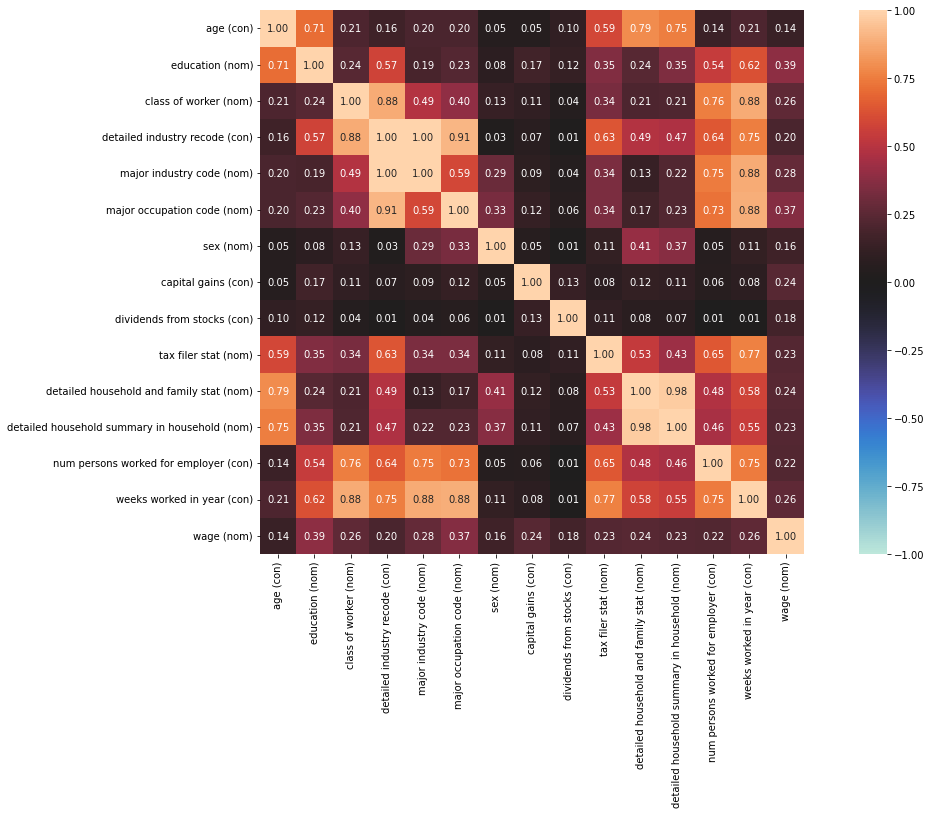

In [228]:
nominal.associations(train_df, figsize=(20,10), mark_columns=True);

Some of these features are highly correlated with one another, it makes sense to remove these as we want to start simple as they may add complexity to any model we train and not provide much useful information

In [229]:
remove_cols = ['detailed industry recode', 'detailed household and family stat']

train_df = train_df[[col for col in train_df.columns if col not in remove_cols]]
test_df = test_df[[col for col in test_df.columns if col not in remove_cols]]

As we saw in the previous notebook, a few of these features have lots of classes, some of only have a few datapoints. It might make sense to bin these if we can into more general classes

In [230]:
for col in train_df.columns:
    print(train_df[col].value_counts())
    print('----')

34    3489
35    3450
36    3353
31    3351
33    3340
      ... 
85     423
86     348
87     301
88     241
89     195
Name: age, Length: 91, dtype: int64
----
 High school graduate                      48407
 Children                                  47422
 Some college but no degree                27820
 Bachelors degree(BA AB BS)                19865
 7th and 8th grade                          8007
 10th grade                                 7557
 11th grade                                 6876
 Masters degree(MA MS MEng MEd MSW MBA)     6541
 9th grade                                  6230
 Associates degree-occup /vocational        5358
 Associates degree-academic program         4363
 5th or 6th grade                           3277
 12th grade no diploma                      2126
 1st 2nd 3rd or 4th grade                   1799
 Prof school degree (MD DDS DVM LLB JD)     1793
 Doctorate degree(PhD EdD)                  1263
 Less than 1st grade                         819
Name:

Looking at the above, we will bin `['weeks worked in year','capital gains', 'dividends from stocks', 'education']` as they have clear groupings. Also would like to condense `class of worker` to move `Without pay, Never worked & Not in universe` to the same label as the former 2 provide similar information relating to `wage`

In [231]:
train_df['class of worker'].value_counts()

 Not in universe                   100245
 Private                            72028
 Self-employed-not incorporated      8445
 Local government                    7784
 State government                    4227
 Self-employed-incorporated          3265
 Federal government                  2925
 Never worked                         439
 Without pay                          165
Name: class of worker, dtype: int64

In [232]:
def bin_numerical_column(df, col, bins):
    """
    Separates numerical column into bins,
    converts type to string for future preprocessing
    """
    df[col + '_bins'] = pd.cut(df[col], bins=bins, include_lowest = True).apply(lambda x: str(x)).astype(str)
    print('binned column name:', col + '_bins')


In [233]:
col_bins = {'weeks worked in year' :[0,1,51,52],
            'capital gains': [0,1,100,5000,10000,99999],
            'dividends from stocks': [0,1,100,5000,10000,99999],
            'age': [0,18,29,35,45,55,65,75,90]}

for col in ['weeks worked in year','capital gains', 'dividends from stocks', 'age']:
    bin_numerical_column(train_df, col, bins=col_bins[col])
    bin_numerical_column(test_df, col, bins=col_bins[col])
    

binned column name: weeks worked in year_bins
binned column name: weeks worked in year_bins
binned column name: capital gains_bins
binned column name: capital gains_bins
binned column name: dividends from stocks_bins
binned column name: dividends from stocks_bins
binned column name: age_bins
binned column name: age_bins


Lets condense / bin `education` now:

It seems logical to move everything below `High school graduate` into the same label, combine `Bachelors / Masters`, `Doctorate / Prof school` and `some college / asssociate degrees`

In [234]:
train_df['education'].value_counts()

 High school graduate                      48407
 Children                                  47422
 Some college but no degree                27820
 Bachelors degree(BA AB BS)                19865
 7th and 8th grade                          8007
 10th grade                                 7557
 11th grade                                 6876
 Masters degree(MA MS MEng MEd MSW MBA)     6541
 9th grade                                  6230
 Associates degree-occup /vocational        5358
 Associates degree-academic program         4363
 5th or 6th grade                           3277
 12th grade no diploma                      2126
 1st 2nd 3rd or 4th grade                   1799
 Prof school degree (MD DDS DVM LLB JD)     1793
 Doctorate degree(PhD EdD)                  1263
 Less than 1st grade                         819
Name: education, dtype: int64

In [235]:
educ_dict = {'no_high_school': [' Less than 1st grade',
                                ' 1st 2nd 3rd or 4th grade',
                                ' 5th or 6th grade',
                                ' 7th and 8th grade', 
                                ' 9th grade', 
                                ' 10th grade', 
                                ' 11th grade', 
                                ' 12th grade no diploma'],
                   
'college_no_deg_or_assoc': [' Some college but no degree',
                            ' Associates degree-occup /vocational',
                            ' Associates degree-academic program'],
 
'bsc_msc': [' Bachelors degree(BA AB BS)',
            ' Masters degree(MA MS MEng MEd MSW MBA)'],
 
'postgrad+': [' Doctorate degree(PhD EdD)',
              ' Prof school degree (MD DDS DVM LLB JD)']
}

In [236]:
for key, col_values in educ_dict.items():
    
    for value in col_values:
        
        train_df.loc[train_df['education'] == value, 'education'] = key
        test_df.loc[test_df['education'] == value, 'education'] = key

In [237]:
train_df['education'].value_counts()

 High school graduate      48407
 Children                  47422
college_no_deg_or_assoc    37541
no_high_school             36691
bsc_msc                    26406
postgrad+                   3056
Name: education, dtype: int64

Interesting to note that all `education = " Children"` have a `wage` < 50000 - which makes sense as they are ineligible to work, may make sense to remove from dataset as they are automatically a < 50000 prediction and may not contribute information to the model?

In [238]:
train_df.loc[train_df['education']==' Children', 'wage'].value_counts()

 - 50000.    47422
Name: wage, dtype: int64

In [239]:
test_df.loc[test_df['education']==' Children', 'wage'].value_counts()

 - 50000.    23442
Name: wage, dtype: int64

And now to move `Without pay, Never worked & Not in universe` to the same label 

In [240]:
train_df.loc[train_df['class of worker'].isin([' Without pay', ' Never worked', ' Not in universe']), 'class of worker'] = 'nui_nw_wp'
test_df.loc[test_df['class of worker'].isin([' Without pay', ' Never worked', ' Not in universe']), 'class of worker'] = 'nui_nw_wp'

In [241]:
train_df['class of worker'].value_counts()

nui_nw_wp                          100849
 Private                            72028
 Self-employed-not incorporated      8445
 Local government                    7784
 State government                    4227
 Self-employed-incorporated          3265
 Federal government                  2925
Name: class of worker, dtype: int64

#### Encoding columns

Want to convert our categorical data into numerical so it can be read by our model. There are two ways of doing this:

1. `one-hot encoding` where we split the column into N columns (N=number of classes of the column) and assign a value of 1 to the column with the label and 0 to the rest
2. `ordinal encoding` where we map the categorical label to a list of integers 0-N, this is useful when there is a ranking between the labels

We will `ordinal encode` columns such as `education, class of worker, weeks_worked_in_year_bins, dividends_from_stocks_bins, capital_gains_bins` where there is a ranking to the labels.

For columns `major industry code, major occupation code, tax filer stat, detailed household summary in household` we will `one-hot encode` them as it is less clear if they are ordinal

In [242]:
one_hot_cols = ['major industry code', 'major occupation code', 'tax filer stat', 
                'detailed household summary in household', 'class of worker']

ordinal_cols = ['education', 'class of worker', 'weeks_worked_in_year_bins', 
                'dividends_from_stocks_bins', 'capital_gains_bins']               

`num persons worked for employer` is conveniently ordinally encoded for us and we will simply map the values of `sex` to 0 & 1

In [202]:
train_df['sex'] = train_df['sex'].map({' Female': 1, ' Male': 0})
test_df['sex'] = test_df['sex'].map({' Female': 1, ' Male': 0})

In [203]:
def one_hot_encode_concat(df, column):

    '''one-hot encode and then concat onto original df while dropping original column'''
    
    dummy_vars = pd.get_dummies(df[[column]])
    ndf = pd.concat([df, dummy_vars], axis=1)
    ndf = ndf.drop(columns=[column])
    
    return ndf

In [204]:
for col in one_hot_cols:

    train_df = one_hot_encode_concat(train_df, col)
    test_df = one_hot_encode_concat(test_df, col)

In [205]:
# Incase the test_df one hot encoded columns are missing a value found in the training set, 
# we will add the column and assign it a value of 0
for col in [t for t in train_df.columns if t not in test_df.columns]:
    test_df[col] = 0

Map our ordinal columns:

In [206]:
edu_mapping = {' Children': 0,
               'no_high_school': 1,
               ' High school graduate': 2,
               'college_no_deg_or_assoc': 3,
               'bsc_msc': 4,
               'postgrad+': 5}

train_df['education'] = train_df['education'].map(edu_mapping)

test_df['education'] = test_df['education'].map(edu_mapping)

In [207]:
wwy_mapping = {'(-0.001, 1.0]': 0,
               '(1.0, 51.0]': 1,
               '(51.0, 52.0]': 2}

train_df['weeks worked in year_bins'] = train_df['weeks worked in year_bins'].map(wwy_mapping)

test_df['weeks worked in year_bins'] = test_df['weeks worked in year_bins'].map(wwy_mapping)

In [208]:
train_df.age_bins.value_counts()

(-0.001, 18.0]    58476
(35.0, 45.0]      30817
(18.0, 29.0]      29658
(45.0, 55.0]      22082
(29.0, 35.0]      20021
(55.0, 65.0]      15730
(65.0, 75.0]      13576
(75.0, 90.0]       9163
Name: age_bins, dtype: int64

In [209]:
age_mapping = {'(-0.001, 18.0]': 0,
               '(18.0, 29.0]': 1,
               '(29.0, 35.0]': 2,
               '(35.0, 45.0]': 3,
               '(45.0, 55.0]': 4,
               '(55.0, 65.0]': 5,
               '(65.0, 75.0]': 6,
               '(75.0, 90.0]': 7}

train_df['age_bins'] = train_df['age_bins'].map(age_mapping)

test_df['age_bins'] = test_df['age_bins'].map(age_mapping)

In [210]:
cap_gains_dividends_map = {'(-0.001, 1.0]': 0,
                           '(1.0, 100.0]': 1,
                           '(100.0, 5000.0]': 2,
                           '(5000.0, 10000.0]': 3,
                           '(10000.0, 99999.0]': 4}

train_df['capital gains_bins'] = train_df['capital gains_bins'].map(cap_gains_dividends_map)
train_df['dividends from stocks_bins'] = train_df['dividends from stocks_bins'].map(cap_gains_dividends_map)

test_df['capital gains_bins'] = test_df['capital gains_bins'].map(cap_gains_dividends_map)
test_df['dividends from stocks_bins'] = test_df['dividends from stocks_bins'].map(cap_gains_dividends_map)


Now we will remove unwanted columns remaining:

In [261]:
train_df = train_df.drop(columns=['capital gains','weeks worked in year','dividends from stocks', 'age'])
test_df = test_df.drop(columns=['capital gains','weeks worked in year','dividends from stocks', 'age'])

#### Balancing data

We have a clear mismatch is the number of target variable labels:

In [243]:
train_df['wage'].value_counts()

 - 50000.    187141
 50000+.      12382
Name: wage, dtype: int64

This could lead to our model overfitting and just simply predicting `-50000` as it will see that the vast majority of it's inputs are that. There are a couple of simple techniques to avoid this, we could either `undersample` from our majority class or `oversample` from them minority class.

Since I do not want to lose potentially useful data, I will choose to `oversample` from the minority class to make sure the model is trained on all data.

In [244]:
# Find roughly how many times more the majority class is present
sample_number = int(np.round(train_df.wage.value_counts()[0]/train_df.wage.value_counts()[1]))

In [245]:
# Duplicate the minority class `sample_number` many times:
train_df = pd.concat([train_df, pd.concat([train_df[train_df.wage==' 50000+.']]*(sample_number-1), ignore_index=True)])

In [246]:
train_df['wage'].value_counts()

 - 50000.    187141
 50000+.     185730
Name: wage, dtype: int64

#### Shuffle dataset

In [247]:
train_df = train_df.sample(frac=1)

#### Binarize our `wage` column

In [248]:
train_df['wage'] = train_df['wage'].map({' 50000+.': 0,
                                         ' - 50000.': 1})

test_df['wage'] = test_df['wage'].map({' 50000+.': 0,
                                       ' - 50000.': 1})

#### Separate out of training features and target variable:

In [262]:
feature_cols = [col for col in train_df.columns if col!='wage']

In [265]:
X_train = train_df.loc[:, feature_cols]
X_test = test_df.loc[:, feature_cols]

y_train = train_df.wage.values
y_test = test_df.wage.values

#### MinMaxScale our features

This transforms each of ours feature to a range of values between 0 and 1, the transformation is given by:

`X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min`

The idea is to bring all of our features to the same scale of values as larger values tend to have more influence on the model learning than smaller ones

In [219]:
mm_scaler = MinMaxScaler()
X_train_minmax = mm_scaler.fit_transform(X_train)
X_test_minmax = mm_scaler.transform(X_test)

In [258]:
y_test.values

array([1, 1, 1, ..., 1, 1, 1])

In [220]:
X_train_minmax

array([[0.4       , 1.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.6       , 0.        , 0.16666667, ..., 1.        , 0.        ,
        0.        ],
       [0.2       , 1.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.6       , 0.        , 1.        , ..., 0.        , 0.        ,
        1.        ],
       [0.2       , 1.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.4       , 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ]])

#### Save for training:

In [259]:
np.save('data/data_train.npy', X_train_minmax)
np.save('data/labels_train.npy', y_train)
np.save('data/data_test.npy', X_test_minmax)
np.save('data/labels_test.npy', y_test)